## B. Implement 2D Convolution in Python (no libraries)

### 2. Vectorisation, no for loops

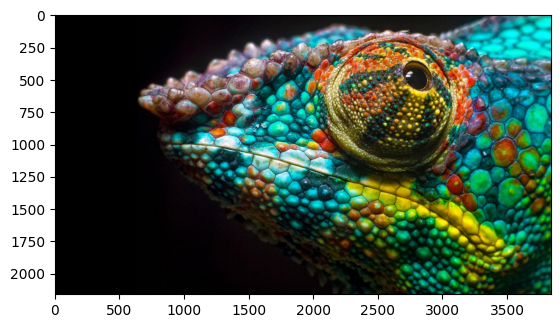

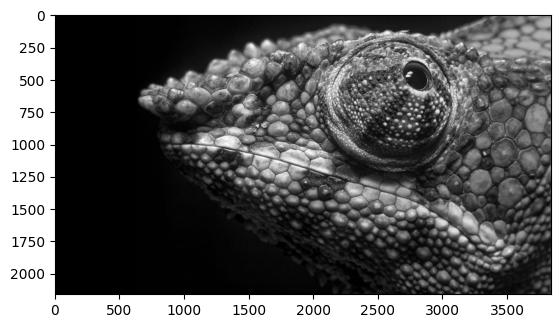

In [187]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

org = cv2.imread('../../images/chameleon.jpg')
plt.imshow(cv2.cvtColor(org,cv2.COLOR_BGR2RGB))
plt.show()
greyorg = cv2.cvtColor(org,cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(greyorg,cv2.COLOR_BGR2RGB))
plt.show()


In [188]:
# greyorg_resized = cv2.resize(greyorg, (greyorg.shape[1]//26,greyorg.shape[0]//26))
greyorg_resized = cv2.resize(greyorg, (greyorg.shape[1]//18,greyorg.shape[0]//18))
print(greyorg_resized.shape)

(120, 213)


In [189]:
# 2d convolution using matrix multiplication
# Done by creating a doubly blocked circulant matrix using toeplitz matrices for each row of the filter with the elements of the convolution matrix K, keeping all other elements of the matrix as 0,
# and converting the input image channel M into a column vector of size N times M
# this one is not working for large signals due to memory constraints
"""
import numpy as np

def create_toeplitz(vector, rows, columns):
    # check if vector is an array or a matrix
    if np.isscalar(vector[0]):  # Handle scalar values
        matrix = np.zeros((rows, columns))
    else:  # Handle vector[0] as a matrix
        matrix = np.zeros((rows, columns), dtype=object)
        
    for i in range(rows):
        for j in range(columns):
            if i - j >= 0:
                print(i, j)
                matrix[i][j] = vector[i - j]
            else:
                if np.isscalar(vector[0]):
                    matrix[i][j] = 0
                else:
                    matrix[i][j] = np.zeros_like(vector[0])  # Set to a zero matrix if same shape as a row toeplitz
    return matrix

def filter_matrix(k,matrsize, num_rows, num_columns):
    # create convolution matrix
    k = 1/(matrsize*matrsize)*np.array([[1 for i in range(matrsize)] for j in range(matrsize)])
    # create toeplitz matrix for each row
    rows_toeplitz = []
    for i in range(num_rows):
        toeplitz_row = create_toeplitz(k[i],k.shape[0],k.shape[1]-1)
        rows_toeplitz.append(toeplitz_row)

    # create doubly blocked circulant matrix using the row toeplitz matrices
    filter = create_toeplitz(rows_toeplitz,np.array(rows_toeplitz).size,np.array(rows_toeplitz).size-1)
    return filter

def convovle(img,matrsize):
    # create convolution matrix
    k = 1/(matrsize*matrsize)*np.array([[1 for i in range(matrsize)] for j in range(matrsize)])
    
    # define the convolution
    y = img.flatten()
    num_columns = img.shape[0]*img.shape[1]
    num_rows = matrsize
    filter = filter_matrix(k,matrsize,num_rows,num_columns)
    y = np.matmul(filter,y)

    # reshape y to image
    y = np.reshape(y,(img.shape[0],img.shape[1]))
    return y

vanillaconvolved = convolve(greyorg,3)
matrsize = 3
k = np.array(1/(matrsize*matrsize)*np.array([[i+j for i in range(matrsize)] for j in range(matrsize)]))
print(k.shape)    
"""

'import numpy as np\n\ndef create_toeplitz(vector, rows, columns):\n    # check if vector is an array or a matrix\n    if np.isscalar(vector[0]):  # Handle scalar values\n        matrix = np.zeros((rows, columns))\n    else:  # Handle vector[0] as a matrix\n        matrix = np.zeros((rows, columns), dtype=object)\n        \n    for i in range(rows):\n        for j in range(columns):\n            if i - j >= 0:\n                print(i, j)\n                matrix[i][j] = vector[i - j]\n            else:\n                if np.isscalar(vector[0]):\n                    matrix[i][j] = 0\n                else:\n                    matrix[i][j] = np.zeros_like(vector[0])  # Set to a zero matrix if same shape as a row toeplitz\n    return matrix\n\ndef filter_matrix(k,matrsize, num_rows, num_columns):\n    # create convolution matrix\n    k = 1/(matrsize*matrsize)*np.array([[1 for i in range(matrsize)] for j in range(matrsize)])\n    # create toeplitz matrix for each row\n    rows_toeplitz = 

In [190]:
import numpy as np
from scipy.linalg import toeplitz


def flatten_matrix(matrix):
    # get a vector of size n times m from the input matrix I
    h, w = matrix.shape
    flattened = np.zeros(h * w, dtype=matrix.dtype)
    # in the vector form, the last row should come first. So flip the matrix I vertically (along horizontal axis) and then get the vector from it
    matrix_flipped = np.flipud(matrix)
    for row_idx in range(h):
        start_idx = row_idx * w
        flattened[start_idx: start_idx + w] = matrix_flipped[row_idx]
    return flattened


def reshape_vector(vector, target_shape):
    # convert the result vector to a matrix with the required dimensions after zero padding
    height, width = target_shape
    reshaped_matrix = np.zeros(target_shape, dtype=vector.dtype)
    for row_idx in range(height):
        reshaped_matrix[row_idx, :] = vector[row_idx * width: (row_idx + 1) * width]
    # flip the output matrix up-down to get correct result
    return np.flipud(reshaped_matrix)


def convolution_with_multiplication(input_matrix, filter_matrix):
    # number of columns and rows of the input
    input_h, input_w = input_matrix.shape

    # number of columns and rows of the filter
    filter_h, filter_w = filter_matrix.shape

    # calculate the output dimensions for full convolution
    output_h = input_h + filter_h - 1
    output_w = input_w + filter_w - 1

    # zero pad the filter matrix F to perform full convolution on the matrix I
    filter_padded = np.pad(filter_matrix, 
                           ((output_h - filter_h, 0), (0, output_w - filter_w)),
                           mode='constant')

    # create a toeplitz matrix using each row of the F matrix after zero padding
    toeplitz_blocks = []
    for row in range(filter_padded.shape[0] - 1, -1, -1):
        row_data = filter_padded[row, :]
        first_column = np.r_[row_data[0], np.zeros(input_w - 1)]
        toeplitz_matrix = toeplitz(row_data, first_column)
        toeplitz_blocks.append(toeplitz_matrix)

    # use the toeplitz matrices created from each row of F to make a doubly blocked matrix (of the form of a toeplitz matrix with the arrangement of row toeplitz submatrices)
    block_mapping_column = np.arange(1, filter_padded.shape[0] + 1)
    block_mapping_row = np.r_[block_mapping_column[0], np.zeros(input_h - 1, dtype=int)]
    block_index = toeplitz(block_mapping_column, block_mapping_row)

    # create the doubly blocked matrix
    single_block_shape = toeplitz_blocks[0].shape
    doubly_blocked_matrix = np.zeros((single_block_shape[0] * block_index.shape[0],
                                      single_block_shape[1] * block_index.shape[1]))

    # fill the doubly blocked matrix with corresponding toeplitz blocks
    block_h, block_w = single_block_shape
    for row in range(block_index.shape[0]):
        for col in range(block_index.shape[1]):
            row_start = row * block_h
            col_start = col * block_w
            doubly_blocked_matrix[row_start:row_start + block_h, 
                                  col_start:col_start + block_w] = toeplitz_blocks[block_index[row, col] - 1]

    # flatten the matrix I to create a vector of size rows_I*columns_I
    input_vector = flatten_matrix(input_matrix)

    # multiply the doubly blocked matrix created using matrix F and the vector made using the matrix I
    result_vector = np.dot(doubly_blocked_matrix, input_vector)

    # reshape the result vector back into matrix form with the correct dimensions
    result_matrix = reshape_vector(result_vector, (output_h, output_w))

    return result_matrix

In [191]:
from time import time
from scipy import signal

# convolution with random inputs
# I = np.random.randn(80, 85)
# F = np.random.rand(100,105)

matrsize = 10
k = 1/(matrsize*matrsize)*np.array([[1 for i in range(matrsize)] for j in range(matrsize)])
start = time()
vanilla_result = convolution_with_multiplication(greyorg_resized, k)
time_vanillaconv = time() - start
print('my result: \n', vanilla_result)
    
from scipy import signal
start = time()
lib_result = signal.convolve2d(greyorg_resized, k, "full")
time_libconv = time() - start
print('lib result: \n', lib_result)

assert(vanilla_result.all() == lib_result.all())

# check error between the two outputs:
print(vanilla_result == lib_result)

my result: 
 [[ 0.    0.    0.   ...  4.08  2.83  1.4 ]
 [ 0.    0.    0.   ...  8.36  5.69  2.8 ]
 [ 0.    0.    0.   ... 13.57  9.19  4.53]
 ...
 [ 0.    0.    0.   ...  4.69  2.75  1.68]
 [ 0.    0.    0.   ...  3.16  1.86  1.  ]
 [ 0.    0.    0.   ...  1.43  0.99  0.49]]
lib result: 
 [[ 0.    0.    0.   ...  4.08  2.83  1.4 ]
 [ 0.    0.    0.   ...  8.36  5.69  2.8 ]
 [ 0.    0.    0.   ... 13.57  9.19  4.53]
 ...
 [ 0.    0.    0.   ...  4.69  2.75  1.68]
 [ 0.    0.    0.   ...  3.16  1.86  1.  ]
 [ 0.    0.    0.   ...  1.43  0.99  0.49]]
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True False  True]
 [ True  True  True ...  True False  True]
 ...
 [ True  True  True ...  True  True False]
 [ True  True  True ... False  True  True]
 [ True  True  True ...  True  True  True]]


### Error:



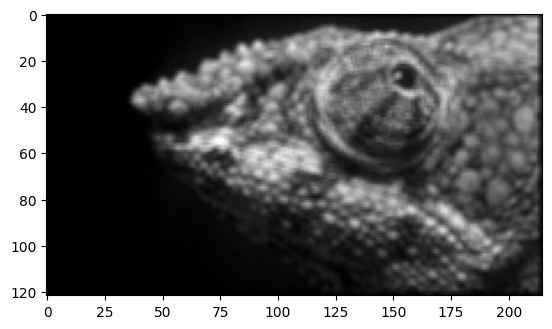

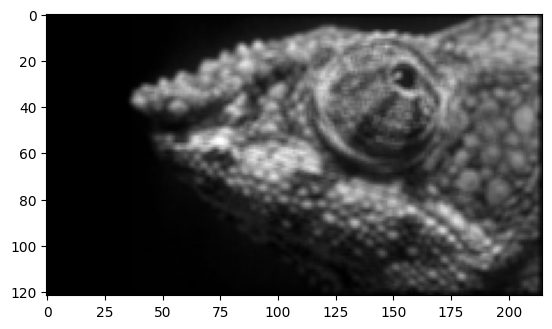

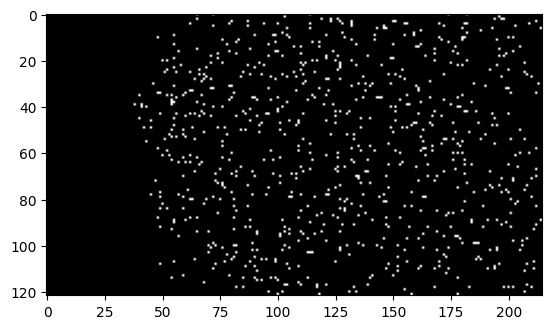

In [198]:
matrsize = 3
k = 1/(matrsize*matrsize)*np.array([[1 for i in range(matrsize)] for j in range(matrsize)])
start = time()
vanilla_result = convolution_with_multiplication(greyorg_resized, k)
time_vanillaconv = time() - start
    
from scipy import signal
start = time()
lib_result = signal.convolve2d(greyorg_resized, k, "full")
time_libconv = time() - start

assert(vanilla_result.all() == lib_result.all())
plt.imshow(vanilla_result.astype(np.int64),cmap='gray')
plt.show()
plt.imshow(lib_result.astype(np.int64),cmap='gray')
plt.show()
plt.imshow(np.abs(vanilla_result.astype(np.int64) - lib_result.astype(np.int64)),cmap='gray')

### Difference in the outputs:

There are small differences in the intensity of the outputs in the two smoothened images. This can probably be explained by floating point errors resulting from calculations using floating point numbers, which can have different precision in the scipy implementation as compared to mine

### Time Difference:

In [199]:
print("Vanilla implementation using toeplitz matrices:",time_vanillaconv,"(Python)")
print("Library implementation using scipy:",time_libconv,"C")
print("Difference:",time_vanillaconv-time_libconv)

Vanilla implementation using toeplitz matrices: 2.193220853805542 (Python)
Library implementation using scipy: 0.0008089542388916016 C
Difference: 2.1924118995666504


### 3. Using FFT 

In [194]:
import cv2
cv2blurred = cv2.blur(greyorg_resized,(10,10))
print(greyorg_resized.shape)

(120, 213)


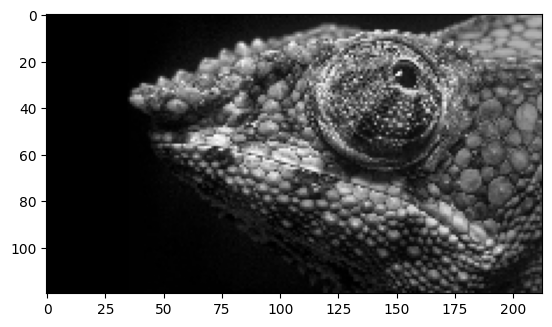

Image FFT:


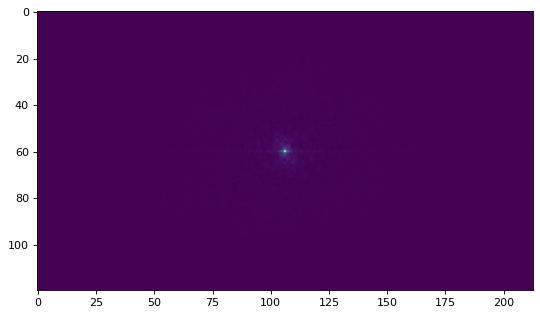

Filter FFT:


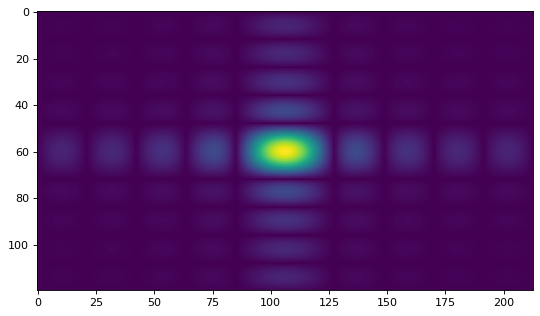

FFT convolved:
(120, 213)


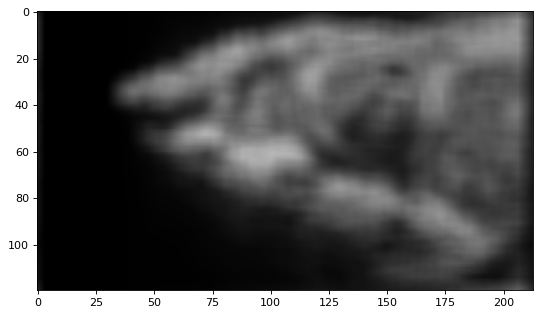

Library convolved:
(120, 213)


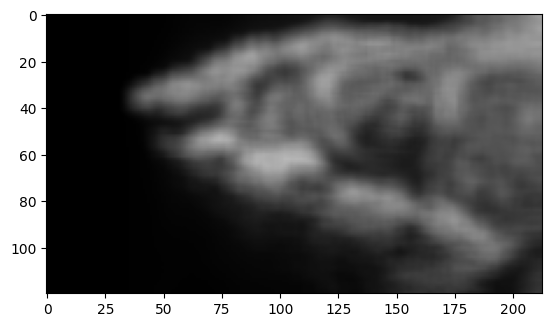

Difference:


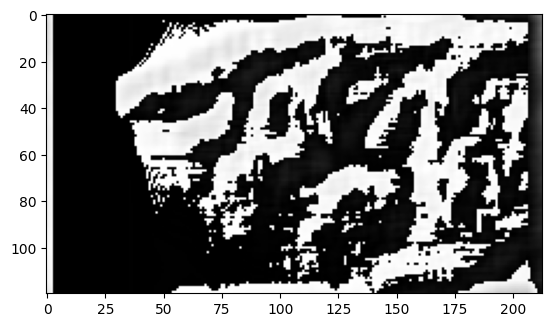

In [195]:
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import uniform_filter

matrsize = 10

plt.imshow(cv2.cvtColor(greyorg_resized,cv2.COLOR_BGR2RGB))
plt.show()
grey_fourier = fft2(greyorg_resized)
plt.figure(num=None, figsize=(8, 6), dpi=80)
print("Image FFT:")
plt.imshow(abs(fftshift(grey_fourier)))
plt.show()
# create filter matrix
k = 1/(matrsize*matrsize)*np.array([[1 for i in range(matrsize)] for j in range(matrsize)])
k_padded = np.pad(k, ((int(np.floor((greyorg_resized.shape[0] - k.shape[0]) / 2)),int(np.ceil((greyorg_resized.shape[0] - k.shape[0]) / 2))), (int(np.floor((greyorg_resized.shape[1] - k.shape[1]) / 2)),int(np.ceil((greyorg_resized.shape[1] - k.shape[1]) / 2)))))
filter_fourier = fft2(k_padded)
plt.figure(num=None, figsize=(8, 6), dpi=80)
print("Filter FFT:")
plt.imshow(abs(fftshift(filter_fourier)))
plt.show()

# convolution through fft multiplication
fftconv = grey_fourier*filter_fourier
plt.figure(num=None, figsize=(8, 6), dpi=80)

# inverse fft
convolved = np.abs(fftshift(ifft2(fftconv))).astype(np.uint8)
print("FFT convolved:")
print(convolved.shape)
plt.imshow(cv2.cvtColor(convolved,cv2.COLOR_BGR2RGB))
plt.show()

print("Library convolved:")
print(cv2blurred.shape)
plt.imshow(cv2.cvtColor(cv2blurred,cv2.COLOR_BGR2RGB))
plt.show()

print("Difference:")
plt.imshow(cv2.cvtColor(cv2blurred - convolved,cv2.COLOR_BGR2RGB))

In [265]:
# Time comparison
from time import time
import cv2

# Using FFT:

start = time()
k = 1/(matrsize*matrsize)*np.array([[1 for i in range(matrsize)] for j in range(matrsize)])
k_padded = np.pad(k, ((int(np.floor((greyorg_resized.shape[0] - k.shape[0]) / 2)),int(np.ceil((greyorg_resized.shape[0] - k.shape[0]) / 2))), (int(np.floor((greyorg_resized.shape[1] - k.shape[1]) / 2)),int(np.ceil((greyorg_resized.shape[1] - k.shape[1]) / 2)))))
filter_fourier = fft2(k_padded)

# convolution through fft multiplication
fftconv = grey_fourier*filter_fourier

# inverse fft
convolved = np.abs(fftshift(ifft2(fftconv))).astype(np.uint8)
fft_time = time() - start

print("FFT:",fft_time, "(Implemented in python)")

# Using scipy:
start = time()
librayconvolved = cv2.blur(greyorg_resized,(10,10))
cv2blur_time = time() - start
print("CV2 Blur:",cv2blur_time,"(Built in C++)")

FFT: 0.03809785842895508 (Implemented in python)
CV2 Blur: 0.0039060115814208984 (Built in C++)


In [266]:
print("Difference:",fft_time-cv2blur_time)

Difference: 0.03419184684753418


### Difference in the outputs:

Both, the FFT implementation and the cv2.blur() library implementation use the moving average filter as the kernel.

However, there is a difference in the outputs of the two. This can be because of precision errors which arise due to numerical approximations in the FFT, especially when converting back from the frequency domain to the spaicl domain of the image, which can result in small differences in the intensity values of the pixels.

Additionally, differences can arise because of the circular convolution used in the FFT instead of the linear convolution of the spacial moving average filter.